## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
nomatch1 = df.query("landing_page == 'new_page' and group != 'treatment'").shape[0]

In [7]:
nomatch2 = df.query("landing_page != 'new_page' and group == 'treatment'").shape[0]

In [8]:
nomatch1 + nomatch2

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.    

a. Now create a new dataset that meets the specifications.

In [10]:
df2 = df.copy()
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
df2 = df2.loc[~((df2.landing_page != 'new_page') & (df2.group == 'treatment')), :]
df2 = df2.loc[~((df2.landing_page == 'new_page') & (df2.group != 'treatment')), :]
df2 = df2.loc[~((df2.landing_page != 'old_page') & (df2.group == 'control')), :]
df2 = df2.loc[~((df2.landing_page == 'old_page') & (df2.group != 'control')), :]

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2['user_id'].duplicated(keep=False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(df2.index[1899], inplace=True)

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.query('converted == 1')['user_id'].nunique() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('converted == 1 and group == "treatment"')['user_id'].nunique() / df2.query('group == "control"')['user_id'].nunique()

0.11883832508449609

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('converted == 1 and group == "treatment"')['user_id'].nunique() / df2.query('group == "treatment"')['user_id'].nunique()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query('converted == 1 and group == "treatment"')['user_id'].nunique() / df2.query('group == "treatment"')['user_id'].nunique()

0.11880806551510564

e. Use the results in the previous two portions of this question to suggest if there is evidence that one page leads to more conversions? 

In [21]:
df2.timestamp.min()

'2017-01-02 13:42:05.378582'

In [22]:
df2.timestamp.max()

'2017-01-24 13:41:54.460509'

In [23]:
actual_dif = df2[df2['group'] == 'control'].converted.mean() - df2[df2['group'] == 'treatment'].converted.mean()
actual_dif

0.0015798852878394776

**Since the study was run for roughly three weeks, 29,000 users were surveyed, and the users were evenly distributed as having received the new_page or old_page, I believe that the data is sufficient to be confident in the results. Thus the probability of someone converting on the old page is .15% higher than the new, which is not enough for statistical significance, or to combat neither the error nor change aversion. It would be safe to conclude we should continue using the old_page**

<a id='ab_test'></a>
### Part II - A/B Test 


`1.`Make a decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what would the null and alternative hypotheses be? 

**Hypothesis: New_page - Old_page <= 0**

**Alternative: New_page - Old_page > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
p_new = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_new

0.11959749882133504

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_old

0.11959749882133504

c. What is $n_{new}$?

In [26]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique() 
n_old

145273

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0,1], n_new, p=(p_new,1-p_new))

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted.mean() - old_page_converted.mean()

8.567359486810755e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [31]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [32]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

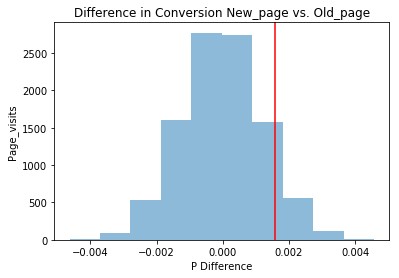

In [33]:
plt.hist(p_diffs, alpha=.5)
plt.title('Difference in Conversion New_page vs. Old_page');
plt.xlabel('P Difference');
plt.ylabel('Page_visits');
plt.axvline(x=actual_dif,color ='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
size = df2.shape[0]
convert_new =  df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
convert_old =  df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
actual_new = convert_new/n_new
actual_old = convert_old/n_old
obs_diff = actual_new - actual_old
null_vals = np.random.normal(0, np.std(p_diffs), size)
(null_vals > obs_diff).mean()

0.9031261184373538

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Since the type 1 error rate is 5% and the proportion of p_diffs greater than the actual differerence is .09, we have failed to reject the null hypothesesis. The p is greater than the alpha, so the result is rendered statistically insignificant.**

**The p-value measures the level of statistical significance within the hypothesis test, representing the probability of the occurrence of a hypothesis event. The alpha is the level of risk an individual is willing to take given that a type 1 error occurs. Since our p-value exceeds the risk level, or the alpha, we have failed to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145273, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
zscore, pvalue = sm.stats.proportions_ztest([convert_new, convert_old], np.array([n_new, n_old]), alternative = 'larger')
zscore, pvalue

(-1.3116083211881657, 0.90517383802520912)

In [37]:
from scipy.stats import norm

norm.cdf(zscore)

0.094826161974790879

In [38]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the zscore is 1.31, and thus smaller than the critical value of 1.96, we have failed to reject the null hypothesis. As this is a two-option test, the score would need to be +-1.96 for the results to be significant. This means the conversion rate for the new page is not higher by a large enough margin for the company to overcome the type 1 error rate and make the change worth it.** 

**Because the statistical significance is .1 and not closer to 1, we can draw the conclusion that our results are not statistically signifiicant. The results are the same as j and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['ab_page'] = pd.get_dummies(df2['group']).treatment
df2['intercept'] = 1 

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.722
Date:                Sun, 22 Jul 2018   Prob (F-statistic):              0.189
Time:                        18:28:42   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.312      0.189      -0.004       0.001
==============================================================================
Omnibus:                   125553.453   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.338
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**The p-value is 1.89. This differs because they have different variables. Part 2 assumes the old is better based on 95% confidence. In this regression, we assume treatment and control are equally likely.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more terms into the regression model makes interpretting the data more complex, and it is easy to misinterpret the results. Additionally, this may cause us to insert a higher-order term for better results**

** One term that could be added is the timestamp. This could help us understand when a page was favored over the others or if there was a time shift from one page to the other.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. Read in the **countries.csv** dataset and merge together datasets on the approporiate rows.

Does it appear that country had an impact on conversion? 

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])

h. Look at an interaction between page and country to see if there significant effects on conversion.  

In [44]:
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'uk', 'us']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Jul 2018   Pseudo R-squ.:               2.325e-05
Time:                        18:28:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1757
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.248      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
uk             0.0506      0.028      1.784      0.075      -0.005       0.106
us             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [45]:
1/np.exp(-.0150), np.exp(.0506), np.exp(.0408)

(1.0151130646157189, 1.0519020483004984, 1.0416437559600236)

<a id='conclusions'></a>
## Conclusions

For every one unit increase in new_page, there will likely be a 1.015 x increase in converted, given all other variables are constant

For every one unit increase in users from the UK, there will likely be a 5% increase in converting, given all other variables are constant

For every one unit increase in users from the US, there will likely be a 4% increase in converting, given all other variables are constant

Also,only intercept's p-value is less than 0.05, which is statistically significant enough for converted rate. Other varables in the summary are not statistically significant. 

Additionally, Z-score for all X variables are not large enough to be significant for predicting converted rate. 

Therefore, the country a user lives is not significant on the converted rate considering the page the user land in. 

Convert is 1.08 times more likely to happen for UK and new page users than CA and new page users, holding all other varible constant.

Convert is 1.04 times more likely to happen for US and new page users than CA and new page users, holding all other varible constant.

<a id='conclusions'></a>
## Finishing Up


## Directions to Submit

In [46]:
#Extra Credit: Convert two tailed to one tailed 
# p value from one tailed test Part II = .90517383802520912
two_tailed_p = .90517383802520912/2
direction_p = 1-.90517383802520912
two_tailed_p, direction_p

(0.45258691901260456, 0.09482616197479088)

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0